Goal - explore LEACE, and produce an efficient implementation function


end goal:
1. LEACE

Using device: cuda
Generated data shape: torch.Size([500, 5])
Covariance matrix:
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 4.0518e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0070e-05, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0001e-05, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-05]],
       device='cuda:0')


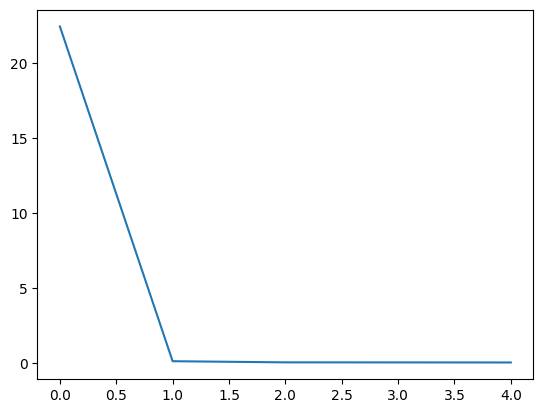

In [1]:
import torch
import torch

def generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=2.0, epsilon=1e-5, device=torch.device("cpu"), seed=42):
    """
    Generates a Gaussian dataset with a power law diminishing covariance matrix.
    
    """

    # Set the random seed for reproducibility
    torch.manual_seed(seed)
    
    # Create a vector of variances that decay with power law.
    # Variance for feature i: 1/(i+1)^alpha + epsilon
    indices = torch.arange(1, n_features + 1, dtype=torch.float32, device=device)
    variances = 1.0 / (indices ** alpha) + epsilon
    
    # Build the diagonal covariance matrix
    cov_matrix = torch.diag(variances)
    
    # Define the zero mean for all features
    mean = torch.zeros(n_features, device=device)
    
    # Create the multivariate normal distribution and sample data
    distribution = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov_matrix)
    data = distribution.sample((n_samples,))
    
    return data, cov_matrix
# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

n_samples = 500
n_features = 5
alpha = 15  # Adjust alpha to change the rate of decay

# Generate the dataset and obtain the covariance matrix used
data, cov_matrix = generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device)

print("Generated data shape:", data.shape)
print("Covariance matrix:\n", cov_matrix)

# Compute the empirical covariance matrix of the generated data for verification
data_centered = data - data.mean(dim=0, keepdim=True)
emp_cov = torch.mm(data_centered.t(), data_centered) / (n_samples - 1)

# Print the empirical covariance matrix
U, S, V = torch.svd(data_centered)
# plot S
import matplotlib.pyplot as plt
plt.plot(S.cpu().numpy())
plt.show()

Using device: cuda


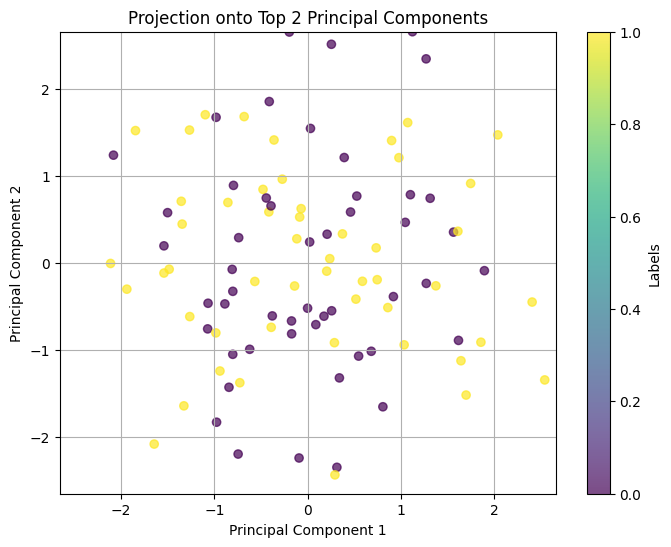

In [10]:
import torch
import matplotlib.pyplot as plt

def plot_top2_pcs_torch(data, title="Projection onto Top 2 Principal Components", labels=None):
    """
    Computes the top two principal components using PyTorch and plots the data
    projected onto these components.
    """
    # Center the data (zero mean)
    data_centered = data - data.mean(dim=0, keepdim=True)
    
    # Compute the covariance matrix (n_features x n_features)
    n_samples = data_centered.shape[0]
    cov_matrix = torch.mm(data_centered.T, data_centered) / (n_samples - 1)
    
    # Eigen-decomposition of the covariance matrix (eigenvalues in ascending order)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    
    # Select the top 2 eigenvectors (columns corresponding to the largest eigenvalues)
    top2_eigenvectors = eigenvectors[:, -2:]  # shape: (n_features, 2)
    
    # Project the centered data onto the top 2 principal components
    projected_data = torch.mm(data_centered, top2_eigenvectors)  # shape: (n_samples, 2)
    
    # Convert to numpy arrays for plotting (ensure data is on CPU)
    projected_np = projected_data.cpu().numpy()
    if labels is not None:
        if isinstance(labels, torch.Tensor):
            labels_np = labels.cpu().numpy()
        else:
            labels_np = labels
    else:
        labels_np = None
    
    # Plot the data
    plt.figure(figsize=(8, 6))
    if labels_np is None:
        plt.scatter(projected_np[:, 0], projected_np[:, 1], alpha=0.7)
    else:
        scatter = plt.scatter(projected_np[:, 0], projected_np[:, 1],
                              c=labels_np, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label="Labels")
    
    # make xlim and ylim equal
    x_max = projected_np[:, 0].max()
    x_min = projected_np[:, 0].min()
    y_max = projected_np[:, 1].max()
    y_min = projected_np[:, 1].min()
    max_ = max(abs(x_max), abs(x_min), abs(y_max), abs(y_min))
    min_ = min(abs(x_max), abs(x_min), abs(y_max), abs(y_min))
    plt.xlim(-max_, max_)
    plt.ylim(-max_, max_)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Set device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Generate random data: 100 samples, 5 features
torch.manual_seed(42)
data = torch.randn(100, 5, device=device)

# Optionally, generate some dummy labels (e.g., for binary classes)
labels = torch.randint(0, 2, (100,), device=device)

# Plot the projection of the data on the top 2 principal components
plot_top2_pcs_torch(data, labels=labels)


Using device: cuda
X shape: torch.Size([500, 5])
Covariance of the whitened data:
 tensor([[ 9.9999e-01,  3.0531e-07,  1.5122e-06, -2.7406e-06, -1.0741e-05],
        [ 3.0531e-07,  9.9986e-01,  6.9766e-06,  8.8174e-06,  1.4229e-05],
        [ 1.5122e-06,  6.9766e-06,  9.9907e-01,  9.9859e-05,  1.1832e-04],
        [-2.7406e-06,  8.8174e-06,  9.9859e-05,  9.9750e-01,  8.0644e-05],
        [-1.0741e-05,  1.4229e-05,  1.1832e-04,  8.0644e-05,  9.9370e-01]],
       device='cuda:0')


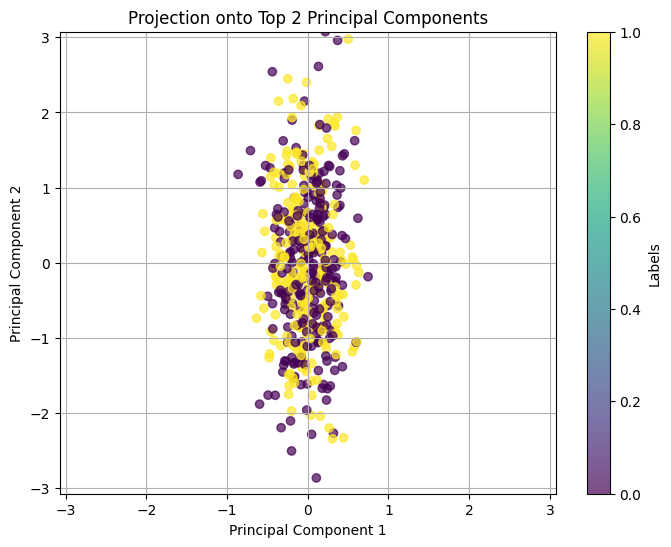

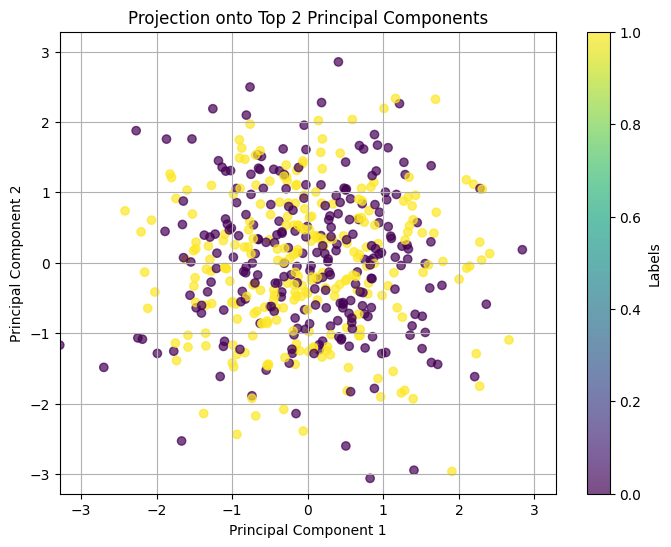

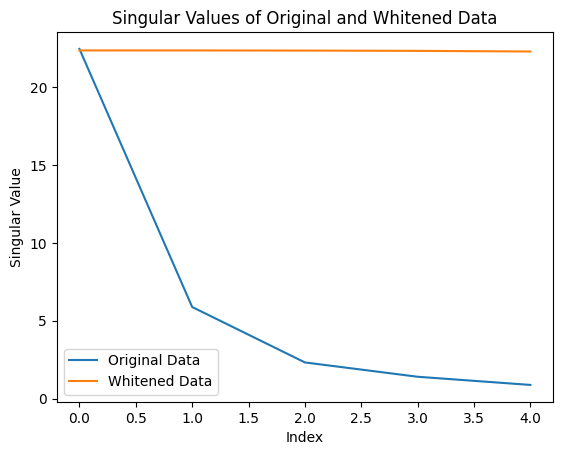

In [12]:
import torch

def whiten_data_torch(X, epsilon=1e-5):
    """
    Whitens the dataset X using eigenvalue decomposition in PyTorch.
    
    The input X should be a tensor of shape (n_samples, n_features). The function centers
    the data and applies the whitening transform so that the output has an (approximately)
    identity covariance matrix.
    
    Parameters:
    - X : torch.Tensor
          Input data of shape (n_samples, n_features).
    - epsilon : float, optional
          Small constant added for numerical stability.
    
    Returns:
    - X_whitened : torch.Tensor
          The whitened data with approximately unit covariance.
    """
    # Center the data (zero mean)
    X_centered = X - torch.mean(X, dim=0, keepdim=True)
    
    # Compute the covariance matrix: (n_features x n_features)
    n_samples = X_centered.size(0)
    cov = torch.mm(X_centered.T, X_centered) / (n_samples - 1)
    
    # Eigen-decomposition of the covariance matrix
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    
    # Create the diagonal matrix for the inverse square root of eigenvalues
    D_inv = torch.diag(1.0 / torch.sqrt(eigenvalues + epsilon))
    
    # Compute the whitening matrix
    whitening_matrix = torch.mm(eigenvectors, torch.mm(D_inv, eigenvectors.T))
    
    # Apply the whitening transformation
    X_whitened = torch.mm(X_centered, whitening_matrix)
    
    return X_whitened

# Select device: use CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Create a random dataset with 100 samples and 5 features on the selected device
torch.manual_seed(42)

#X = torch.randn(100, 5, device=device)
n_samples = 100 
n_features = 5
#X = generate_powerlaw_gaussian_dataset(n_samples, n_features, device)[0]
n_samples = 500
n_features = 5
alpha = 4  # Adjust alpha to change the rate of decay

# Generate the dataset and obtain the covariance matrix used
X, cov_matrix = generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device)

print(f"X shape: {X.shape}")    
# Whiten the dataset
X_white = whiten_data_torch(X)

# Verify that the covariance of the whitened data is approximately the identity matrix
n_samples = X_white.size(0)
cov_whitened = torch.mm(X_white.T, X_white) / (n_samples - 1)
print("Covariance of the whitened data:\n", cov_whitened)

# Optionally, generate some dummy labels (e.g., for binary classes)
labels = torch.randint(0, 2, (n_samples,), device=device)

# plot original data with top pcs

plot_top2_pcs_torch(X, labels=labels)

# plot whitened data
plot_top2_pcs_torch(X_white, labels=labels)
# plot the covariance matrix of the whitened data
U, S, V = torch.svd(X)
U_whitened, S_whitened, V_whitened = torch.svd(X_white)     
plt.plot(S.cpu().numpy(), label='Original Data')
plt.plot(S_whitened.cpu().numpy(), label='Whitened Data')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Original and Whitened Data')
plt.legend()
plt.show()
